![](pics/header.jpg)

# Mahony Filter

Kevin J. Walchko, Phd

3 Jan 2021

---

## References

- [Madgwick, *An efficient orientation filter for inertial and inertial/magnetic sensor arrays*](madgwick.pdf)

## Quaternion Basics

Here we will use Hamiltonian (right-handed) quaternions throughout this work. The notation on the quaternion frames is $^{From}_{To}q$.

$$
^A_Cq = {}^B_Cq \otimes {}^A_Bq \\
^A_Bq = \begin{bmatrix} q_1 & q_2 & q_3 & q_4 \end{bmatrix} \\
^A_Bq^* = {}^B_Aq = \begin{bmatrix} q_1 & -q_2 & -q_3 & -q_4 \end{bmatrix} \\
^Bv = {}^A_Bq \otimes {}^Av \otimes {}^A_Bq^* 
$$

# Filter Equations

Madgwick did a great job designing this filter, but I find his paper hard to follow, especially with several typos in the mathematics. So I tried to boil it down to the useful equations.

![](pics/imu.png)

## Definitions

| Symbol | Definition |
|---|:---|
| $S$ | Sensor Frame |
| $E$ | Earth Frame |
| $||x||$ | Norm of $x$ |
| $f_{g}$ | Objective function|
| $J_{g}$ | Jacobian of the objective funtion based on the gravity reference |
| $\nabla f$ | Gradient of the cost function which is composed of Jacobian and the objective function: $J^T_g f_g$ |
| $\omega_t$ | Raw gyro values |
| $\omega_b$ | Estimated gyro bias |
| $\omega_c$ | Converted gyro values free of biases |
| $a_t$ | accelerometer values |
| $\beta$ | Gain for filter or learning rate based on gradient feedback |
| $^S_Eq_t$ | Orientation at current time step |
| $^Eg$ | Gravitational reference, $\begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$ |


## Initialize

$$
^S_Eq_t = \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \\
^{S}\omega_{b,t} = \begin{bmatrix} 0 & 0 & 0 \end{bmatrix}^T
$$

## Loop

1. Get accelerometer ($^Sa_t$) and gyroscope ($^S\omega_t$) from the IMU
1. Normalize $^Sa_t$
1. Make sure the gyro is converted, if necessary, to rads/sec
1. Calculate time step $\Delta t$ from last sample time
1. Calculate the gradient $\nabla f$ and normalize to get $\frac{\nabla f}{|| \nabla f||}$, the formulation of $\Delta f$ is discussed below in the gradient section
1. Calculate the gyro bias:
    1. Estimate the error [47]: $^{S}\omega_{\epsilon,t} = 2^S_E\hat q^{*}_{est,t-1} \otimes \frac{\nabla f}{|| \nabla f||}$
    1. Integrate (discrete time) to get the current bias estimate [48]: $^{S}\omega_{b,t} = \zeta \sum ^{S}\omega_{\epsilon,t} \Delta t$
        1. $\zeta$ is the drift rate (rad/s/s) $\sqrt{\frac{3}{4}} \dot \omega_{\zeta}$
    1. Correct the raw gyro values [49]: $^{S}\omega_{c,t} = ^{S}\omega_{t} - ^{S}\omega_{b,t}$
1. Update orientation based on corrected gyros [12]: $^{S}_{E}\dot q_{\omega,t} = \frac{1}{2} ^{S}_{E}\hat q_{est,t-1} \otimes ^{S}\omega_{c,t}$
1. Correct the orientation rate using the estimated error [43]: $^{S}_{E}\dot q_{est,t} = ^{S}_{E}\dot q_{\omega,t} - \beta \frac{\nabla f}{|| \nabla f||}$
    1. Now $\beta$ is based on the error (rad/s) of  the gyro, you can use: $\sqrt{\frac{3}{4}} \omega_{\beta}$
1. Integrate (discrete time) the orientation rate to get the updated orientation [42]: $^{S}_{E}\hat q_{est,t} = ^{S}_{E}\hat q_{est,t-1} + ^{S}_{E}\dot q_{est,t} \Delta t$

## Gradient

For the imu filter, the gradient uses [21] and [22]. By substituting in values for gravity ($^Eg = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$) and the magnetic field reference, the equation simplify down to [25],[26]:

$$
\nabla f = J^T_g f_g\\
f_g(^{S}_{E}\hat q_{est,t-1}, a_t) = \begin{bmatrix}
    2(q_2q_4-q_1q_3)-a_x \\
    2(q_1q_2+q_3q_4)-a_y \\
    2(0.5-q_2^2-q_3^2)-a_z
\end{bmatrix} (eqn.25)\\
J_g(^{S}_{E}\hat q_{est,t-1}) = \begin{bmatrix}
    -2q_3 &  2q_4 & -2q_1 & 2q_2 \\
     2q_2 &  2q_1 &  2q_4 & 2q_3 \\
        0 & -4q_2 & -4q_3 &    0
\end{bmatrix} (eqn.26)\\
$$

# Get Data

In [1]:
import numpy as np # matrix manipulations

from ins_nav.filters import Mahony
from ins_nav.storage import from_pickle

from squaternion import Quaternion

from matplotlib import pyplot as plt 

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

In [2]:
!ls -lh *.pkl

-rw-r--r--  1 kevin  staff   586K Jul 10  2022 data-2022-07-10.pkl
-rw-r--r--  1 kevin  staff    49K Jul 10  2022 data-mag-2022-07-10.pkl


In [49]:
filename = "data-mag-2022-07-10.pkl"
datainfo = from_pickle(filename)
data = np.array(datainfo["data"])
print(f">> Found {len(data[:,0])} data points, data is: {data.shape}")

accel = data[:,0:3]
gyro = data[:,3:6] #* np.pi/180
mag = data[:,6:9]
stamp = (data[:,-1] - data[0,-1]) / 1E6

>> Loaded data from data-mag-2022-07-10.pkl
>> Found 513 data points, data is: (513, 11)


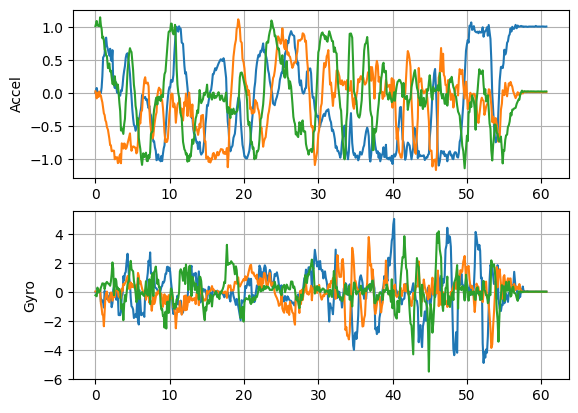

In [50]:
plt.subplot(211); plt.plot(stamp, accel)
plt.ylabel("Accel"); plt.grid(True)
plt.subplot(212); plt.plot(stamp, gyro)
plt.ylabel("Gyro"); plt.grid(True);

# Run AHRS

Now the AHRS uses all of the sensors in the IMU. The code is shown below:

In [51]:
# this seems wrong, give different answer than Wikipedia
# also, his quaternions are different [c(t/2), -r*s(t/2), ...], why negative?
from math import atan2, asin, pi
def euler(q):
    q1,q2,q3,q4 = q
    r2d = 180/pi
    y = atan2(2*q2*q3-2*q1*q4,2*q1**2+2*q2**2-1) * r2d
    p = -asin(2*q2*q4+2*q1*q3) * r2d
    r = atan2(2*q3*q4-2*q1*q2,2*q1**2+2*q4**2-1) * r2d

    # adafruit
#     q0,q1,q2,q3 = q
#     r = atan2(q0 * q1 + q2 * q3, 0.5 - q1 * q1 - q2 * q2) * r2d
#     p = asin(-2.0 * (q1 * q3 - q0 * q2)) * r2d
#     y = atan2(q1 * q2 + q0 * q3, 0.5 - q2 * q2 - q3 * q3) * r2d
    return (r,p,y,)

# Test

Ground truth:

- CW ~390, greater than 1 full rotation
- CCW ~410, back pass the starting point some
- Back to start + ~30, ended CW more than the starting point

In [54]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

start = stamp[0]
last = stamp[0] # starting time stamp
B = sqrt(3/4)*5*pi/180  # gyro measurement error rad/s
filt = Mahony(B)
filt.wcomp = False
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    # q = filt.update(a,g*np.pi/180,dt)  # get orientation
    q = filt.update(a,g,dt)  # get orientation
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["tt"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

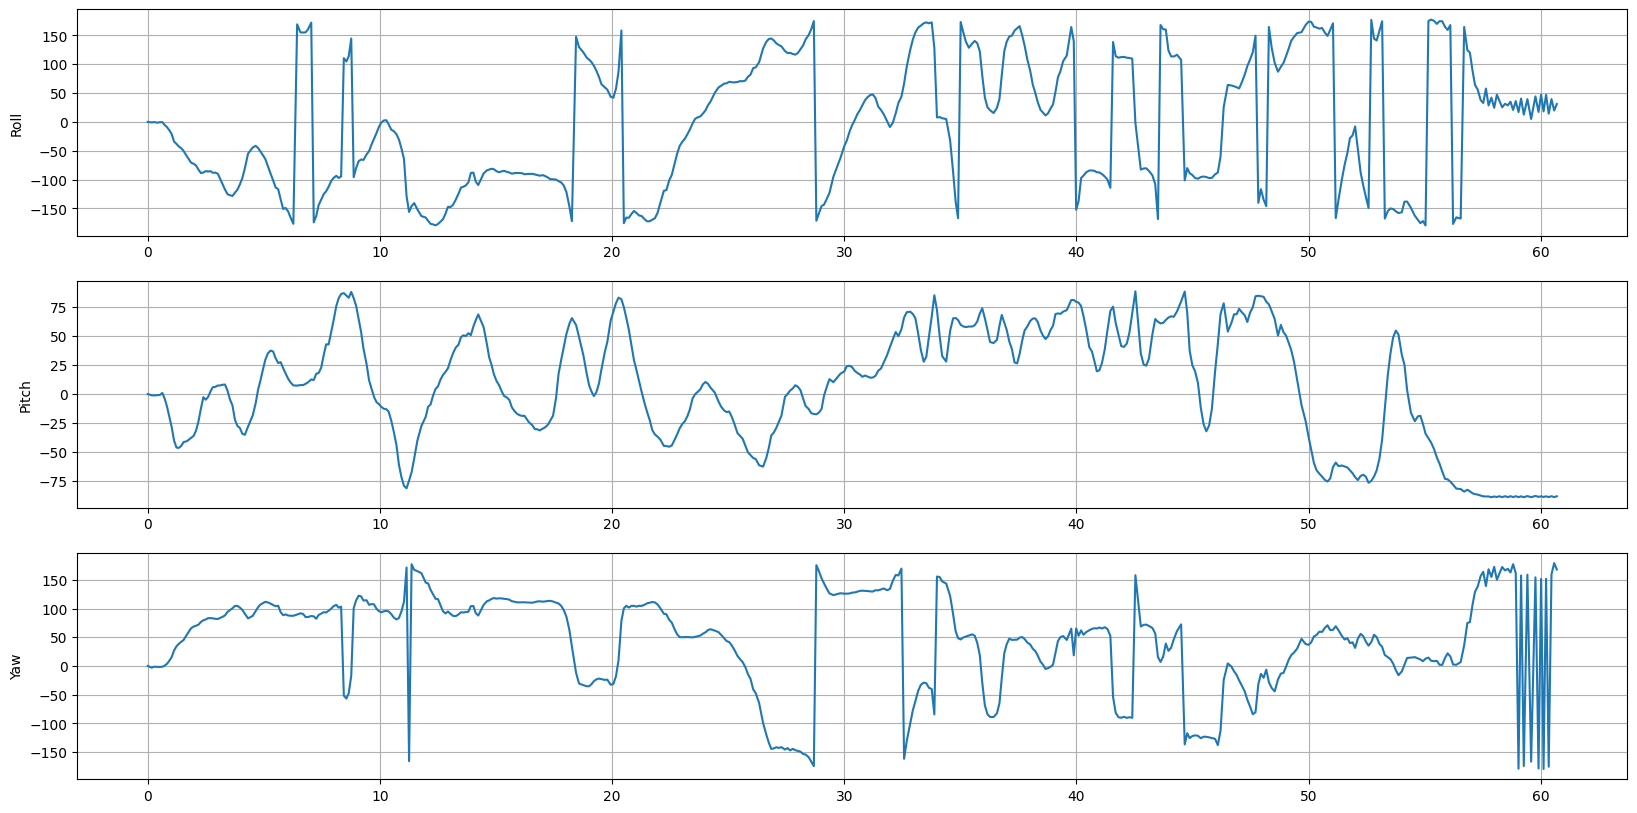

In [55]:
plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(stamp,e["roll"]); plt.ylabel("Roll"); plt.grid(True)
plt.subplot(312)
plt.plot(stamp,e["pitch"]); plt.ylabel("Pitch"); plt.grid(True)
plt.subplot(313)
plt.plot(stamp,e["yaw"]); plt.ylabel("Yaw"); plt.grid(True)


# Appendix: Code

In [21]:
from jtb import getCode

getCode(imp=Mahony)